In [1]:
import warnings
warnings.filterwarnings('ignore')

import glob
import imageio
import json
import numpy as np
import pandas as pd
import os
import marsican_functions as msn
import scipy
import shutil
import tensorflow as tf
import zipfile

from PIL import Image

## Read in data

In [2]:
with open("F:\Colonies_Data\MicrobIA_Dataset_only_counted_processed_anonimyzed_part9\metadata.json", 'r') as f:
    colony_pic_metadata_json = f.read()
    colony_pic_metadata = json.loads(colony_pic_metadata_json)

In [76]:
img_paths = msn.extract_paths_with_colonies(colony_pic_metadata['images_list'])

In [77]:
len(img_paths)

126

## Extract zipfiles

In [25]:
zip_files = glob.glob("F:\Colonies_Data\*.zip")
zip_files

['F:\\Colonies_Data\\MicrobIA_Dataset_only_counted_processed_anonimyzed_part18.zip',
 'F:\\Colonies_Data\\MicrobIA_Dataset_only_counted_processed_anonimyzed_part17.zip',
 'F:\\Colonies_Data\\MicrobIA_Dataset_only_counted_processed_anonimyzed_part15.zip',
 'F:\\Colonies_Data\\MicrobIA_Dataset_only_counted_processed_anonimyzed_part16.zip']

In [26]:
for file_loc in zip_files:
    with zipfile.ZipFile(file_loc, 'r') as zf:
        print(f"Extracting {file_loc}.")
        zf.extractall(path="F:\Colonies_Data\\")
    os.remove(file_loc)
    print(f"Removed {file_loc}.")

Extracting F:\Colonies_Data\MicrobIA_Dataset_only_counted_processed_anonimyzed_part18.zip.
Removed F:\Colonies_Data\MicrobIA_Dataset_only_counted_processed_anonimyzed_part18.zip.
Extracting F:\Colonies_Data\MicrobIA_Dataset_only_counted_processed_anonimyzed_part17.zip.
Removed F:\Colonies_Data\MicrobIA_Dataset_only_counted_processed_anonimyzed_part17.zip.
Extracting F:\Colonies_Data\MicrobIA_Dataset_only_counted_processed_anonimyzed_part15.zip.
Removed F:\Colonies_Data\MicrobIA_Dataset_only_counted_processed_anonimyzed_part15.zip.
Extracting F:\Colonies_Data\MicrobIA_Dataset_only_counted_processed_anonimyzed_part16.zip.
Removed F:\Colonies_Data\MicrobIA_Dataset_only_counted_processed_anonimyzed_part16.zip.


## Finding usable images (Windows)

In [4]:
plate_metadata = glob.glob('F:\Colonies_Data\*\metadata.json')
plate_metadata

['F:\\Colonies_Data\\MicrobIA_Dataset_only_counted_processed_anonimyzed_part9\\metadata.json',
 'F:\\Colonies_Data\\MicrobIA_Dataset_only_counted_processed_anonimyzed_part3\\metadata.json',
 'F:\\Colonies_Data\\MicrobIA_Dataset_only_counted_processed_anonimyzed_part4\\metadata.json',
 'F:\\Colonies_Data\\MicrobIA_Dataset_only_counted_processed_anonimyzed_part1\\metadata.json',
 'F:\\Colonies_Data\\MicrobIA_Dataset_only_counted_processed_anonimyzed_part6\\metadata.json',
 'F:\\Colonies_Data\\MicrobIA_Dataset_only_counted_processed_anonimyzed_part5\\metadata.json',
 'F:\\Colonies_Data\\MicrobIA_Dataset_only_counted_processed_anonimyzed_part2\\metadata.json',
 'F:\\Colonies_Data\\MicrobIA_Dataset_only_counted_processed_anonimyzed_part7\\metadata.json',
 'F:\\Colonies_Data\\MicrobIA_Dataset_only_counted_processed_anonimyzed_part12\\metadata.json',
 'F:\\Colonies_Data\\MicrobIA_Dataset_only_counted_processed_anonimyzed_part8\\metadata.json',
 'F:\\Colonies_Data\\MicrobIA_Dataset_only_counte

In [5]:
all_img_paths = list()
for metadata_loc in plate_metadata:
    absolute_path = metadata_loc.split("\\metadata.json")[0]
    with open(metadata_loc, 'r') as f:
        colony_pic_metadata_json = f.read()
        colony_pic_metadata = json.loads(colony_pic_metadata_json)
    img_paths = msn.extract_paths_with_colonies(colony_pic_metadata['images_list'], max_colonies=99 )
    full_img_paths = [(path[0], absolute_path + '/' + path[1]) for path in img_paths]
    all_img_paths.append(full_img_paths)
all_img_paths = msn.flatten(all_img_paths)

In [6]:
len(all_img_paths)

1204

In [7]:
all_img_paths[0:3]

[(1,
  'F:\\Colonies_Data\\MicrobIA_Dataset_only_counted_processed_anonimyzed_part9/F/T4h_inf/IMG_Niguarda1_127_121_F6_T543.png'),
 (2,
  'F:\\Colonies_Data\\MicrobIA_Dataset_only_counted_processed_anonimyzed_part9/S/T4h_inf/IMG_Niguarda1_1352_710_S54_T962.png'),
 (6,
  'F:\\Colonies_Data\\MicrobIA_Dataset_only_counted_processed_anonimyzed_part9/F/T4h_inf/IMG_Niguarda1_1421_610_F6_T541.png')]

## Image Processing

In [8]:
Lt100_colonies_images = [t[1] for t in all_img_paths]

In [16]:
ex_img_path = Lt100_colonies_images[7]
ex_img = imageio.imread(ex_img_path)

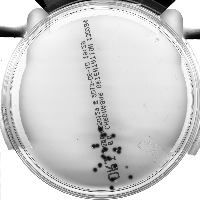

In [17]:
Image.fromarray(ex_img).resize((200, 200)).convert('L')

In [15]:
all_img_paths[7]

(24,
 'F:\\Colonies_Data\\MicrobIA_Dataset_only_counted_processed_anonimyzed_part9/F/T4h_inf/IMG_Niguarda1_1977_767_F6_T967.png')